In [ ]:
import pandas as pd
def load_and_merge_data(fake_path, real_path):
    fake_df = pd.read_csv("//content/fake.csv")
    real_df = pd.read_csv("//content/True.csv")

    fake_df['label'] = 0
    real_df['label'] = 1
    df = pd.concat([fake_df, real_df], axis=0)
    df = df[['text', 'label']]
    df.dropna(inplace=True)
    return df


In [ ]:
df=load_and_merge_data("//content/fake.csv","//content/True.csv")
df.head(10)

,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0
5,The number of cases of cops brutalizing and ki...,0
6,Donald Trump spent a good portion of his day a...,0
7,In the wake of yet another court decision that...,0
8,Many people have raised the alarm regarding th...,0
9,Just when you might have thought we d get a br...,0


In [ ]:
df.shape
df.info()
df['label'].value_counts

<class 'pandas.core.frame.DataFrame'>
Index: 44898 entries, 0 to 21416
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   label   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


<bound method IndexOpsMixin.value_counts of 0        0
1        0
2        0
3        0
4        0
        ..
21412    1
21413    1
21414    1
21415    1
21416    1
Name: label, Length: 44898, dtype: int64>

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)


In [ ]:
df['clean_text'] = df['text'].apply(clean_text)
df[['clean_text', 'label']].head()


,clean_text,label
0,donald trump wish american happy new year leav...,0
1,house intelligence committee chairman devin nu...,0
2,friday revealed former milwaukee sheriff david...,0
3,christmas day donald trump announced would bac...,0
4,pope francis used annual christmas day message...,0


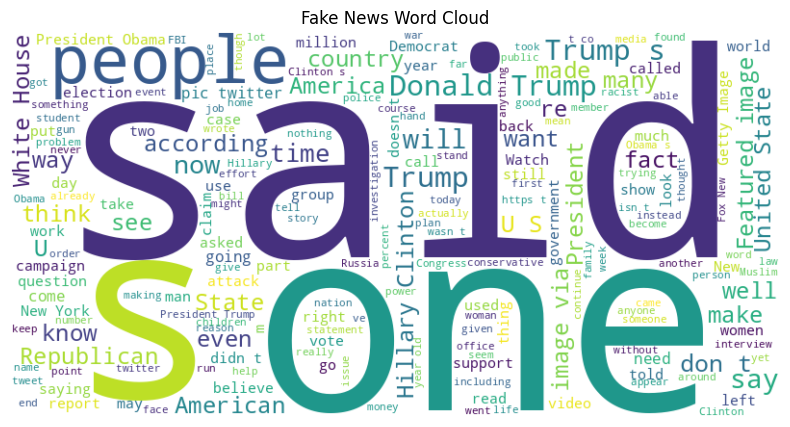

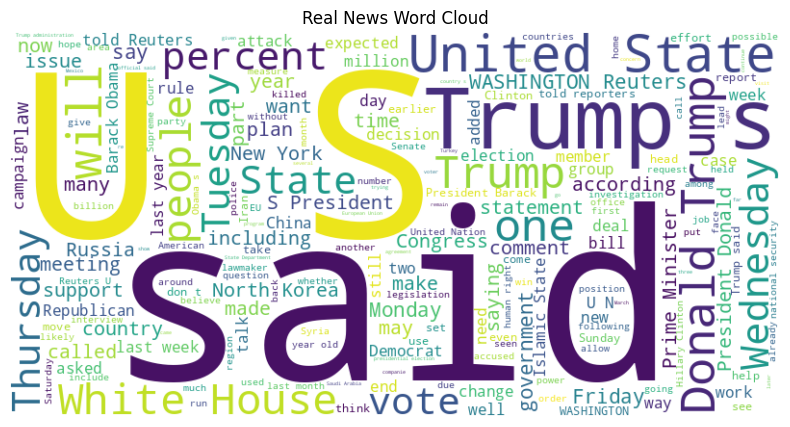

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
fake_text = " ".join(df[df['label'] == 0]['text'])
real_text = " ".join(df[df['label'] == 1]['text'])
def generate_wordcloud(text, title):
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=STOPWORDS,
        max_words=200
    ).generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()
generate_wordcloud(fake_text, "Fake News Word Cloud")
generate_wordcloud(real_text, "Real News Word Cloud")


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(max_features=5000)

X = vectorizer.fit_transform(df['clean_text'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((35918, 5000), (8980, 5000))

In [ ]:
from sklearn.naive_bayes import MultinomialNB
bayes_model = MultinomialNB()
bayes_model.fit(X_train, y_train)


MultinomialNB()

In [ ]:
credibility_scores = bayes_model.predict_proba(X_test)[:, 1]
credibility_scores[:10]


array([0.01879596, 0.95446208, 0.96836105, 0.15749995, 0.94444046,
       0.01038855, 0.01353178, 0.52113345, 0.99105807, 0.69575162])

In [ ]:
y_pred = (credibility_scores >= 0.5).astype(int)
y_pred[:10]


array([0, 1, 1, 0, 1, 0, 0, 1, 1, 1])

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, credibility_scores))


Accuracy: 0.9289532293986636

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93      4733
           1       0.93      0.92      0.92      4247

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980

ROC-AUC: 0.9775979872893212


In [ ]:
from scipy.stats import ttest_ind
real_scores = credibility_scores[y_test == 1]
fake_scores = credibility_scores[y_test == 0]
t_stat, p_value = ttest_ind(real_scores, fake_scores)
print("T-statistic:", t_stat)
print("P-value:", p_value)


T-statistic: 174.1667448134964
P-value: 0.0


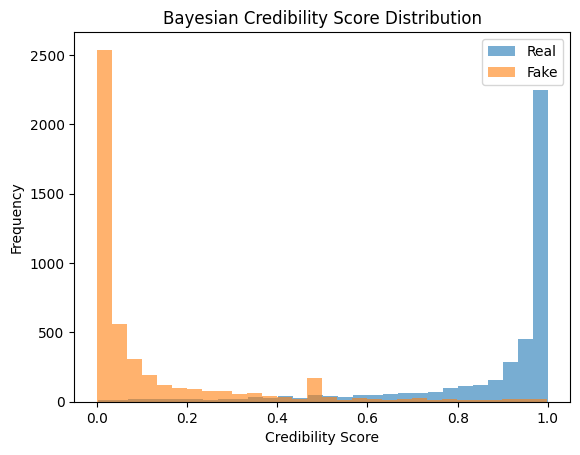

In [ ]:
import matplotlib.pyplot as plt
plt.hist(real_scores, bins=30, alpha=0.6, label='Real')
plt.hist(fake_scores, bins=30, alpha=0.6, label='Fake')
plt.xlabel("Credibility Score")
plt.ylabel("Frequency")
plt.title("Bayesian Credibility Score Distribution")
plt.legend()
plt.show()
